In [88]:
import CalculatedFieldSubroutines as cfs

#

import numpy as np

import pandas as pd

#

import matplotlib.pyplot as plt

import cartopy.crs as ccrs

from cartopy.io.img_tiles import OSM, GoogleTiles, StadiaMapsTiles, MapQuestOSM

from pandasgui import show

#

import warnings

#

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

In [2]:
warnings.filterwarnings( 'ignore' )

In [3]:
gmID_list = cfs.list_whitelisted_gmIDs()

topic_list = cfs.list_topics()

print( topic_list )

['/apollo/canbus/chassis', '/apollo/drive/event', '/apollo/sensor/gnss/best/pose', '/apollo/perception/traffic/light']


In [7]:
index = 5

chassis_df = cfs.retrieve_gmID_topic( gmID_list[ index ], '/apollo/canbus/chassis' )

chassis_df = chassis_df.sort_values( 'time' )

In [8]:
def Acceleration( time_sorted_chassis_df, time_interval = 1 ):

    speedMps_array = np.array( time_sorted_chassis_df[ 'speedMps' ] )

    time_array = np.array( time_sorted_chassis_df[ 'time' ] ) * 1e-9 # seconds

    time_diff_array = np.diff( time_array )

    #

    time_diff_sum = 0

    index_list = []

    list_of_index_lists = []

    for index, time_diff in enumerate( time_diff_array ):

        index_list.append( index )

        time_diff_sum = time_diff_sum + time_diff

        if ( ( time_diff_sum >= time_interval ) or ( index == len( time_diff_array ) - 1 ) ):

            index_list.append( index_list[ -1 ] + 1 )

            list_of_index_lists.append( index_list )

            time_diff_sum = 0

            index_list = []

    #

    acceleration_array = np.array( [ 0. for index in range( len( time_array ) ) ] )

    for ilist in list_of_index_lists:

        speedMps_array_subset = speedMps_array[ ilist ]

        time_array_subset = time_array[ ilist ]

        acceleration = ( speedMps_array_subset[ -1 ] - speedMps_array_subset[ 0 ] ) / ( time_array_subset[ -1 ] - time_array_subset[ 0 ] ) # meters / second ^ 2

        acceleration_array[ ilist ] = acceleration

    time_sorted_chassis_df[ 'Acceleration' ] = acceleration_array

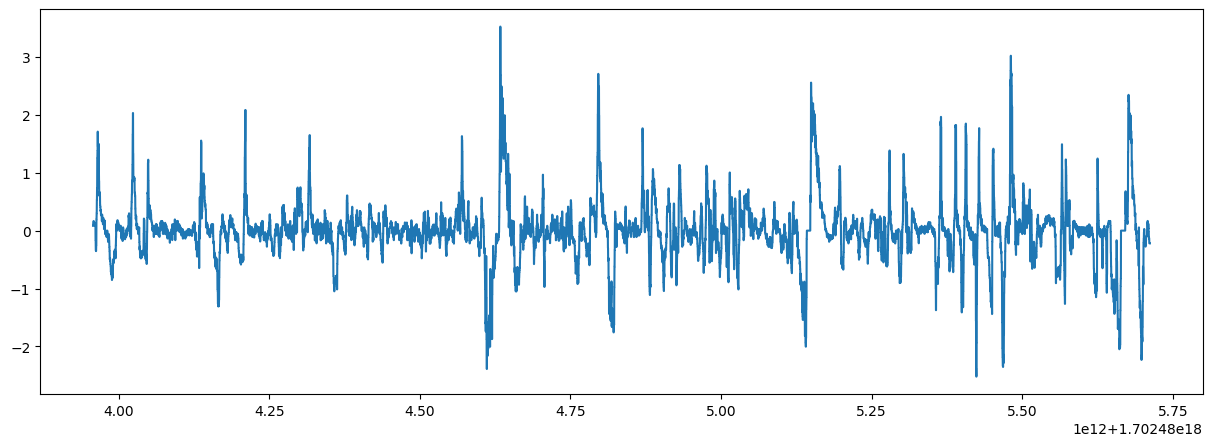

In [9]:
Acceleration( chassis_df, 1 / 3 )

plt.figure( figsize = ( 15, 5 ) )

plt.plot( chassis_df[ 'time' ], chassis_df[ 'Acceleration' ] )

plt.show()

In [10]:
combined_dfs = []

for gmID in gmID_list:

    chassis_df = cfs.retrieve_gmID_topic( gmID, '/apollo/canbus/chassis' )

    best_pose_df = cfs.retrieve_gmID_topic( gmID, '/apollo/sensor/gnss/best/pose' )

    chassis_df = chassis_df.sort_values( 'time' )

    best_pose_df = best_pose_df.sort_values( 'time' )

    #

    Acceleration( chassis_df, 1 / 3 )

    cfs.BinaryDrivingMode( chassis_df )

    cfs.TernaryDrivingModeTransition( chassis_df )

    cfs.DistanceToNearestDisengagement( chassis_df )

    #

    cfs.LatLonTotalStdDev( best_pose_df )

    cfs.ProgressAlongRoute_v2( best_pose_df )

    #

    cfs.ChassisBestPoseMatchedTime( chassis_df, best_pose_df )

    #

    combined_df = pd.merge( chassis_df, best_pose_df, on = 'ChassisBestPoseMatchedTime', how = 'inner' )

    #

    combined_df = combined_df[ [ 'brakePercentage', 'speedMps', 'time_x', 'throttlePercentage', 'steeringPercentage', \
                                 'TernaryDrivingModeTransition', 'DistanceToNearestDisengagement', 'NearestDisengagementID', \
                                 'longitude', 'latitude', 'LatLonTotalStdDev', 'ProgressAlongRoute', 'PartitionNumber', 'Acceleration' ] ]

    combined_dfs.append( combined_df )

In [11]:
combined_df_all = pd.concat( combined_dfs )

In [12]:
combined_df_all[ 'steeringPercentage' ] = np.abs( combined_df_all[ 'steeringPercentage' ] )

In [13]:
limited_stddev_list = []

for stddev in combined_df_all[ 'LatLonTotalStdDev' ]:

    if ( stddev > 10 ):

        stddev = 10

    limited_stddev_list.append( stddev )

combined_df_all[ 'LatLonTotalStdDev' ] = limited_stddev_list

In [14]:
combined_df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11426824 entries, 0 to 55085
Data columns (total 14 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   brakePercentage                 float64
 1   speedMps                        float64
 2   time_x                          int64  
 3   throttlePercentage              float64
 4   steeringPercentage              float64
 5   TernaryDrivingModeTransition    int64  
 6   DistanceToNearestDisengagement  float64
 7   NearestDisengagementID          object 
 8   longitude                       float64
 9   latitude                        float64
 10  LatLonTotalStdDev               float64
 11  ProgressAlongRoute              float64
 12  PartitionNumber                 float64
 13  Acceleration                    float64
dtypes: float64(11), int64(2), object(1)
memory usage: 1.3+ GB


In [15]:
combined_df_all_sliced = combined_df_all[ ( combined_df_all[ 'DistanceToNearestDisengagement' ] > -50 ) &
                                          ( combined_df_all[ 'DistanceToNearestDisengagement' ] < 0 ) ]

In [16]:
disengagement_id_list = list( combined_df_all_sliced[ 'NearestDisengagementID' ].unique() )

In [17]:
desired_colnames = [ 'brakePercentage', 'speedMps', 'throttlePercentage', 'steeringPercentage', 'LatLonTotalStdDev', 'Acceleration' ]

disengagement_df_median = pd.DataFrame()

disengagement_df_mean = pd.DataFrame()

for disengagement_id in disengagement_id_list:

    temp_df = combined_df_all_sliced[ combined_df_all_sliced[ 'NearestDisengagementID' ] == disengagement_id ]

    new_row_median = { colname : np.median( temp_df[ colname ] ) for colname in desired_colnames }

    new_row_median[ 'NearestDisengagementID' ] = disengagement_id

    new_row_mean = { colname : np.mean( temp_df[ colname ] ) for colname in desired_colnames }

    new_row_mean[ 'NearestDisengagementID' ] = disengagement_id

    disengagement_df_median = disengagement_df_median._append( new_row_median, ignore_index = True )

    disengagement_df_mean = disengagement_df_mean._append( new_row_mean, ignore_index = True )

In [18]:
data_to_cluster_df1 = disengagement_df_mean[ [ 'brakePercentage', 'speedMps', 'throttlePercentage', 'steeringPercentage', 'LatLonTotalStdDev' ] ]

data_to_cluster_df2 = disengagement_df_mean[ [ 'speedMps', 'steeringPercentage', 'LatLonTotalStdDev', 'Acceleration' ] ]

In [19]:
def make_elbow_plot( df, n_clusters_range, find_silhouette_score = True ):

    min_num_of_clusters = n_clusters_range[ 0 ]

    max_num_of_clusters = n_clusters_range[ 1 ]

    num_of_clusters_array = np.array( [] )

    inertia_array = np.array( [] )

    silhouette_score_array = np.array( [] )

    for num_of_clusters in range( min_num_of_clusters, max_num_of_clusters ):

        num_of_clusters_array = np.append( num_of_clusters_array, num_of_clusters )

        kmeans_model = KMeans( n_clusters = num_of_clusters, 
                               init = 'k-means++', 
                               n_init = 10, 
                               max_iter = 300,
                               random_state = 0 )

        df_kmeans_clusters = kmeans_model.fit_predict( df )

        inertia = kmeans_model.inertia_

        inertia_array = np.append( inertia_array, inertia )

        if ( find_silhouette_score == True ):

            silhouette = silhouette_score( df, df_kmeans_clusters )

            silhouette_score_array = np.append( silhouette_score_array, silhouette )

    plt.plot( num_of_clusters_array, inertia_array, marker = '.', color = 'black' )

    plt.xlim( min_num_of_clusters - 1, max_num_of_clusters + 1 )

    plt.title( 'Elbow Plot' )

    plt.xlabel( 'Number of Clusters' )

    plt.ylabel( 'Inertia' )

    plt.show()

    if ( find_silhouette_score == True ):

        max_silhouette_score_cluster_num = int( np.argmax( silhouette_score_array ) ) + min_num_of_clusters

        return silhouette_score_array, max_silhouette_score_cluster_num

    else:

        return None, None

In [75]:
scaler = StandardScaler()

disengagement_data_scaler = scaler.fit( data_to_cluster_df1 )

disengagement_data_scaled = disengagement_data_scaler.transform( data_to_cluster_df1 )

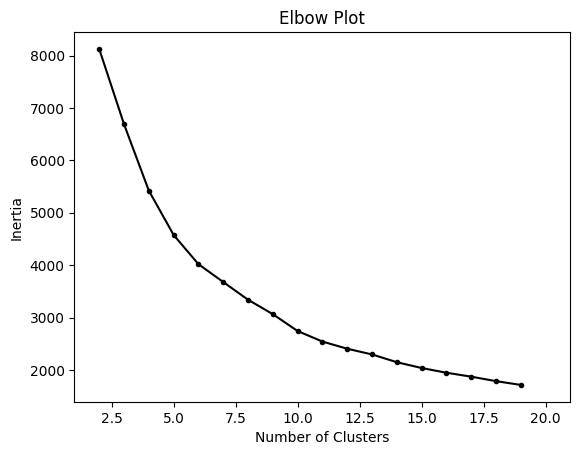

[0.28322427 0.30962177 0.31041568 0.27631316 0.28461888 0.27634672
 0.28457151 0.27114173 0.29821232 0.29161174 0.27327245 0.29012457
 0.2748754  0.27544923 0.26739907 0.2692682  0.27360403 0.27196762]
4


In [76]:
silhouette_score_array, max_silhouette_score_cluster_num = make_elbow_plot( disengagement_data_scaled, 
                                                                            ( 2, 20 ),
                                                                            find_silhouette_score = True )

print( silhouette_score_array )

print( max_silhouette_score_cluster_num )

In [77]:
num_of_clusters = 4

kmeans_model = KMeans( n_clusters = num_of_clusters, 
                       init = 'k-means++', 
                       n_init = 10, 
                       max_iter = 300, 
                       random_state = 0 )

disengagement_data_scaled_kmeans_clusters = kmeans_model.fit_predict( disengagement_data_scaled )

disengagement_df_mean[ 'cluster_num' ] = disengagement_data_scaled_kmeans_clusters

for index, centroid in enumerate( disengagement_data_scaler.inverse_transform( kmeans_model.cluster_centers_ ) ):

    cluster_size = len( disengagement_df_mean[ disengagement_df_mean[ 'cluster_num' ] == index ][ 'cluster_num' ] )

    print( f'Cluster #: { index }' )
    print( f'Cluster Size: { cluster_size }' )
    print( f'Centroid Location:' )

    for col_num, col_name in enumerate( data_to_cluster_df1.columns ):

        print( f'    { col_name }: { centroid[ col_num ] }' )
    
    print( '' )

Cluster #: 0
Cluster Size: 193
Centroid Location:
    brakePercentage: 4.885279770481325
    speedMps: 12.703371101185835
    throttlePercentage: 8.960716826872355
    steeringPercentage: 2.271246080244587
    LatLonTotalStdDev: 3.0011840034856414

Cluster #: 1
Cluster Size: 846
Centroid Location:
    brakePercentage: 22.87628302844457
    speedMps: 9.359430252038642
    throttlePercentage: 2.4164621305397995
    steeringPercentage: 2.2305204223981665
    LatLonTotalStdDev: 0.1518086139397539

Cluster #: 2
Cluster Size: 916
Centroid Location:
    brakePercentage: 3.5024947459766285
    speedMps: 17.785966540420006
    throttlePercentage: 15.237639883562261
    steeringPercentage: 1.4573726470333597
    LatLonTotalStdDev: 0.10489268071030772

Cluster #: 3
Cluster Size: 253
Centroid Location:
    brakePercentage: 18.474112824283615
    speedMps: 4.806092011500829
    throttlePercentage: 4.652235315084582
    steeringPercentage: 17.82173327501409
    LatLonTotalStdDev: 0.28320191965796715

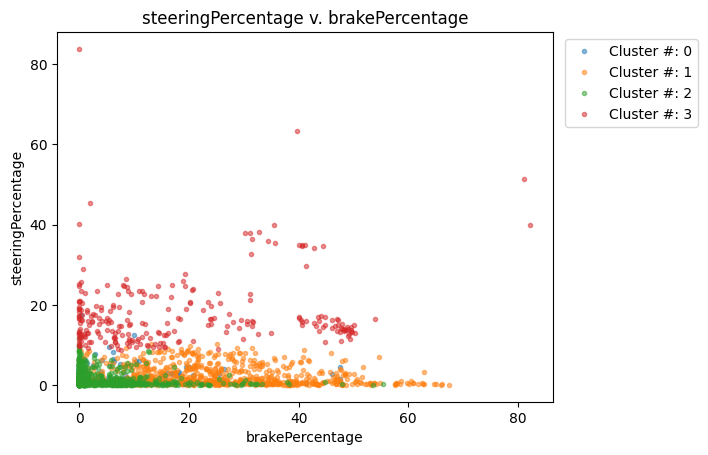

In [78]:
x_colname = 'brakePercentage'

y_colname = 'steeringPercentage'

for cluster_num in range( num_of_clusters ):

    x_array = disengagement_df_mean[ disengagement_df_mean[ 'cluster_num' ] == cluster_num ][ x_colname ]

    y_array = disengagement_df_mean[ disengagement_df_mean[ 'cluster_num' ] == cluster_num ][ y_colname ]

    plt.plot( x_array, y_array, marker = '.', ls = '', label = f'Cluster #: { cluster_num }', alpha = 1 / 2 )


plt.xlabel( f'{ x_colname }' )

plt.ylabel( f'{ y_colname }' )

plt.title( f'{ y_colname } v. { x_colname }' )

plt.legend( bbox_to_anchor = ( 1.01, 1.0 ), loc = 'upper left'  )

plt.show()

In [114]:
scaler = StandardScaler()

disengagement_data_scaler = scaler.fit( data_to_cluster_df2 )

disengagement_data_scaled = disengagement_data_scaler.transform( data_to_cluster_df2 )

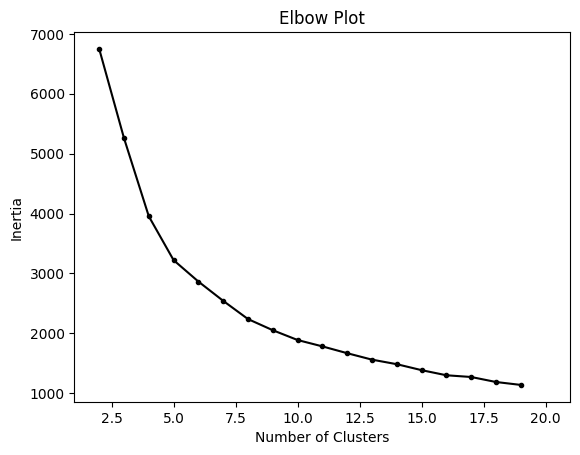

[0.31055479 0.35733202 0.36985666 0.36258154 0.37180452 0.30764409
 0.31515863 0.31990375 0.32566806 0.31854111 0.31342562 0.31713677
 0.30878572 0.30998994 0.32220078 0.31639745 0.31242228 0.31660816]
6


In [115]:
silhouette_score_array, max_silhouette_score_cluster_num = make_elbow_plot( disengagement_data_scaled, 
                                                                            ( 2, 20 ),
                                                                            find_silhouette_score = True )

print( silhouette_score_array )

print( max_silhouette_score_cluster_num )

In [117]:
num_of_clusters = 6

kmeans_model = KMeans( n_clusters = num_of_clusters, 
                       init = 'k-means++', 
                       n_init = 10, 
                       max_iter = 300, 
                       random_state = 0 )

disengagement_data_scaled_kmeans_clusters = kmeans_model.fit_predict( disengagement_data_scaled )

disengagement_df_mean[ 'cluster_num' ] = disengagement_data_scaled_kmeans_clusters

for index, centroid in enumerate( disengagement_data_scaler.inverse_transform( kmeans_model.cluster_centers_ ) ):

    cluster_size = len( disengagement_df_mean[ disengagement_df_mean[ 'cluster_num' ] == index ][ 'cluster_num' ] )

    print( f'Cluster #: { index }' )
    print( f'Cluster Size: { cluster_size }' )
    print( f'Centroid Location:' )

    for col_num, col_name in enumerate( data_to_cluster_df2.columns ):

        print( f'    { col_name }: { centroid[ col_num ]:.2f}' )
    
    print( '' )

Cluster #: 0
Cluster Size: 893
Centroid Location:
    speedMps: 18.42
    steeringPercentage: 1.52
    LatLonTotalStdDev: 0.07
    Acceleration: -0.04

Cluster #: 1
Cluster Size: 14
Centroid Location:
    speedMps: 12.03
    steeringPercentage: 2.28
    LatLonTotalStdDev: 7.69
    Acceleration: -0.21

Cluster #: 2
Cluster Size: 236
Centroid Location:
    speedMps: 11.75
    steeringPercentage: 2.53
    LatLonTotalStdDev: 2.42
    Acceleration: -0.15

Cluster #: 3
Cluster Size: 574
Centroid Location:
    speedMps: 6.17
    steeringPercentage: 2.99
    LatLonTotalStdDev: 0.10
    Acceleration: -0.29

Cluster #: 4
Cluster Size: 272
Centroid Location:
    speedMps: 14.25
    steeringPercentage: 1.12
    LatLonTotalStdDev: 0.06
    Acceleration: -1.34

Cluster #: 5
Cluster Size: 219
Centroid Location:
    speedMps: 4.85
    steeringPercentage: 19.00
    LatLonTotalStdDev: 0.28
    Acceleration: -0.19



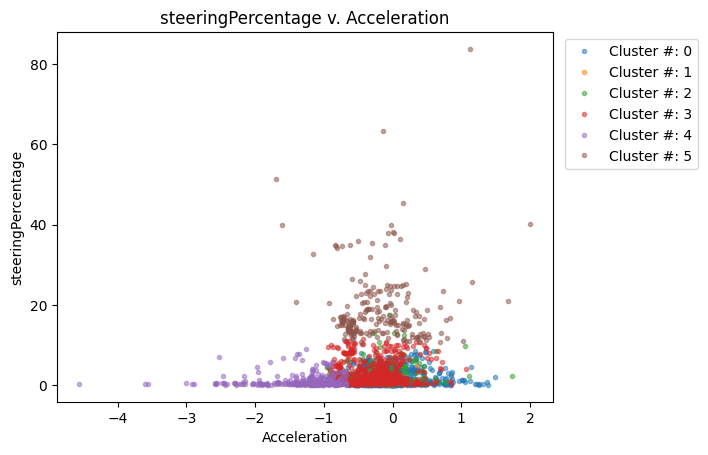

In [118]:
x_colname = 'Acceleration'

y_colname = 'steeringPercentage'

for cluster_num in range( num_of_clusters ):

    x_array = disengagement_df_mean[ disengagement_df_mean[ 'cluster_num' ] == cluster_num ][ x_colname ]

    y_array = disengagement_df_mean[ disengagement_df_mean[ 'cluster_num' ] == cluster_num ][ y_colname ]

    plt.plot( x_array, y_array, marker = '.', ls = '', label = f'Cluster #: { cluster_num }', alpha = 1 / 2 )


plt.xlabel( f'{ x_colname }' )

plt.ylabel( f'{ y_colname }' )

plt.title( f'{ y_colname } v. { x_colname }' )

plt.legend( bbox_to_anchor = ( 1.01, 1.0 ), loc = 'upper left'  )

plt.show()

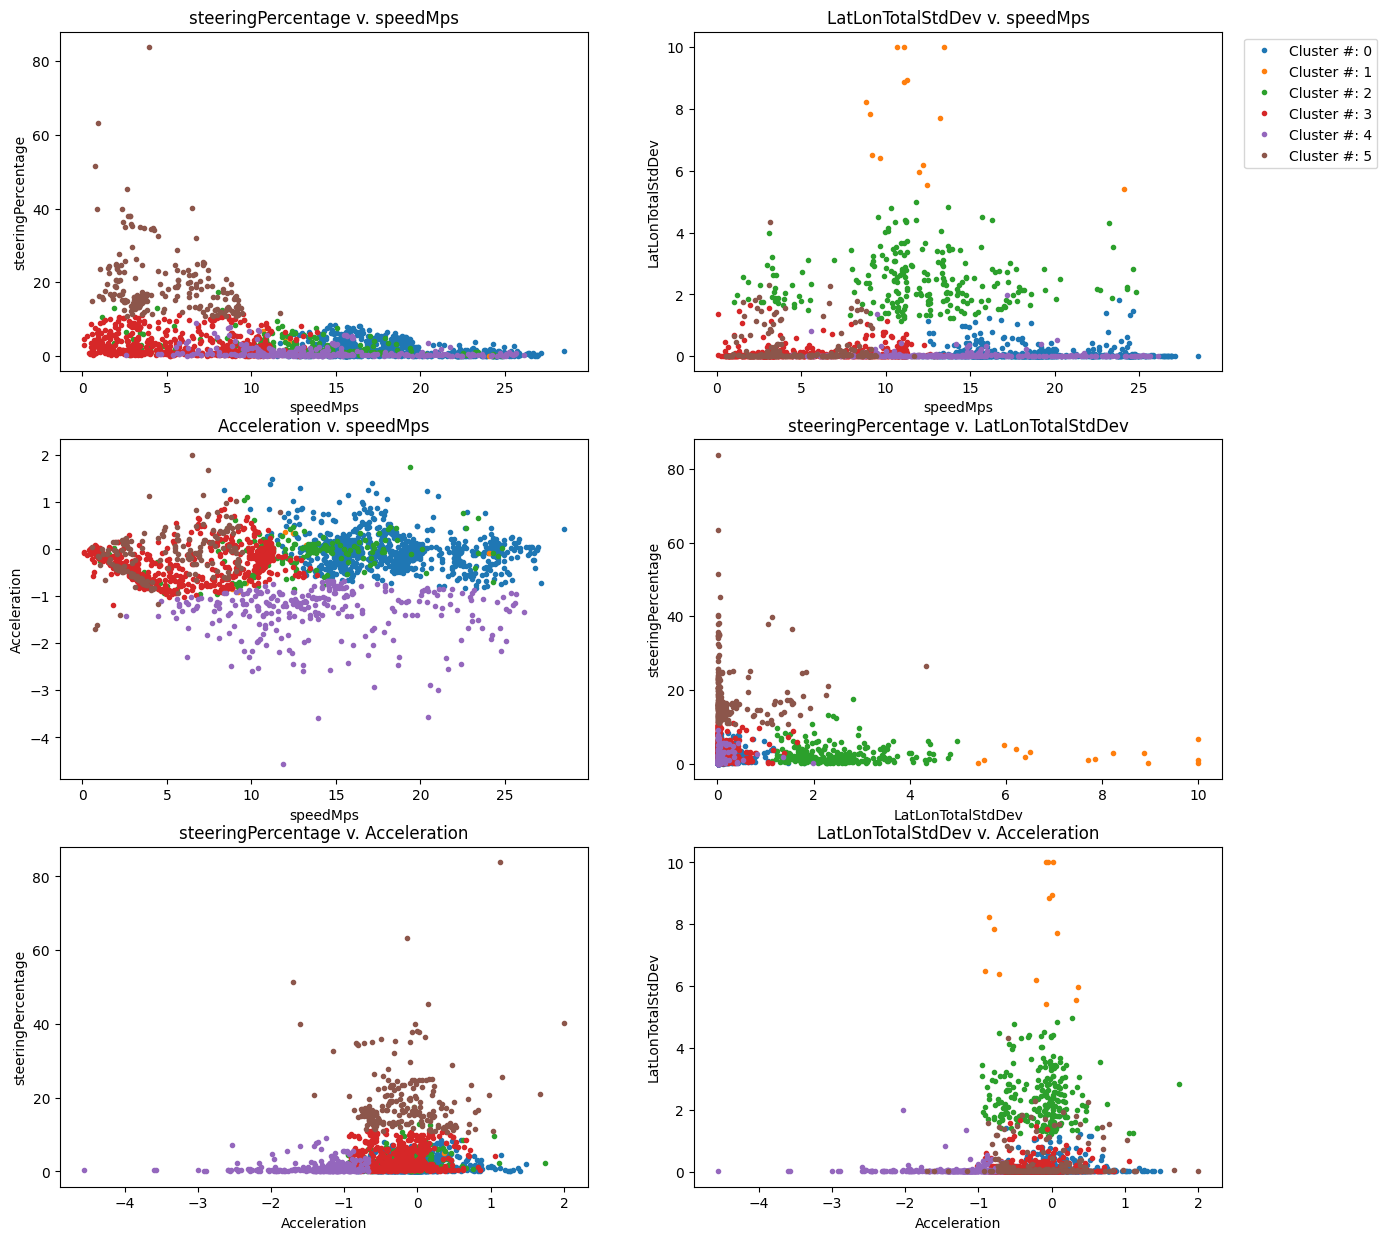

In [119]:
colname_array = np.array( data_to_cluster_df2.columns )

unique_colnum_combination_list_list = [ [ 0, 1 ], [ 0, 2 ], [ 0, 3 ], [ 2, 1 ], [ 3, 1 ], [ 3, 2 ] ]

fig, axes = plt.subplots( 3, 2, figsize = ( 15, 15 ) )

for index, combination in enumerate( unique_colnum_combination_list_list ):

    colnames = list( colname_array[ combination ] )

    x_colname = colnames[ 0 ]

    y_colname = colnames[ 1 ]

    plot_row_num = index // 2

    plot_col_num = index % 2

    for cluster_num in range( num_of_clusters ):

        x_array = disengagement_df_mean[ disengagement_df_mean[ 'cluster_num' ] == cluster_num ][ x_colname ]

        y_array = disengagement_df_mean[ disengagement_df_mean[ 'cluster_num' ] == cluster_num ][ y_colname ]

        axes[ plot_row_num, plot_col_num ].plot( x_array, y_array, marker = '.', ls = '', label = f'Cluster #: { cluster_num }', alpha = 1 )

    axes[ plot_row_num, plot_col_num ].set_xlabel( f'{ x_colname }' )

    axes[ plot_row_num, plot_col_num ].set_ylabel( f'{ y_colname }' )

    axes[ plot_row_num, plot_col_num ].set_title( f'{ y_colname } v. { x_colname }' )

handles, labels = fig.gca().get_legend_handles_labels()

by_label = dict( zip( labels, handles ) )

fig.legend( by_label.values(), by_label.keys(), bbox_to_anchor = ( 0.91, 0.88), loc = 'upper left' )

plt.show()

In [120]:
red_combined_dfs = []

green_combined_dfs = []

blue_combined_dfs = []

for gmID in gmID_list:

    chassis_df = cfs.retrieve_gmID_topic( gmID, '/apollo/canbus/chassis' )

    best_pose_df = cfs.retrieve_gmID_topic( gmID, '/apollo/sensor/gnss/best/pose' )

    chassis_df = chassis_df.sort_values( 'time' )

    best_pose_df = best_pose_df.sort_values( 'time' )

    #

    cfs.BinaryDrivingMode( chassis_df )

    cfs.TernaryDrivingModeTransition( chassis_df )

    cfs.DistanceToNearestDisengagement( chassis_df )

    #

    cfs.ProgressAlongRoute_v2( best_pose_df )

    #

    cfs.ChassisBestPoseMatchedTime( chassis_df, best_pose_df )

    #

    combined_df = pd.merge( chassis_df, best_pose_df, on = 'ChassisBestPoseMatchedTime', how = 'inner' )

    #

    combined_df = combined_df[ [ 'TernaryDrivingModeTransition', 'NearestDisengagementID', 'longitude', 'latitude', 'ProgressAlongRoute' ] ]

    #

    route = cfs.give_route( gmID )

    if ( route == 'Red' ):

        red_combined_dfs.append( combined_df )

    elif ( route == 'Green' ):

        green_combined_dfs.append( combined_df )

    else:

        blue_combined_dfs.append( combined_df )

red_combined_df_all = pd.concat( red_combined_dfs )

green_combined_df_all = pd.concat( green_combined_dfs )

blue_combined_df_all = pd.concat( blue_combined_dfs )

del red_combined_dfs, green_combined_dfs, blue_combined_dfs

In [121]:
red_disengagement_df = pd.merge( red_combined_df_all, disengagement_df_mean, on = 'NearestDisengagementID', how = 'inner' )

red_disengagement_df = red_disengagement_df[ red_disengagement_df[ 'TernaryDrivingModeTransition' ] == -1 ]

red_disengagement_df = red_disengagement_df[ [ 'longitude', 'latitude', 'cluster_num' ] ]

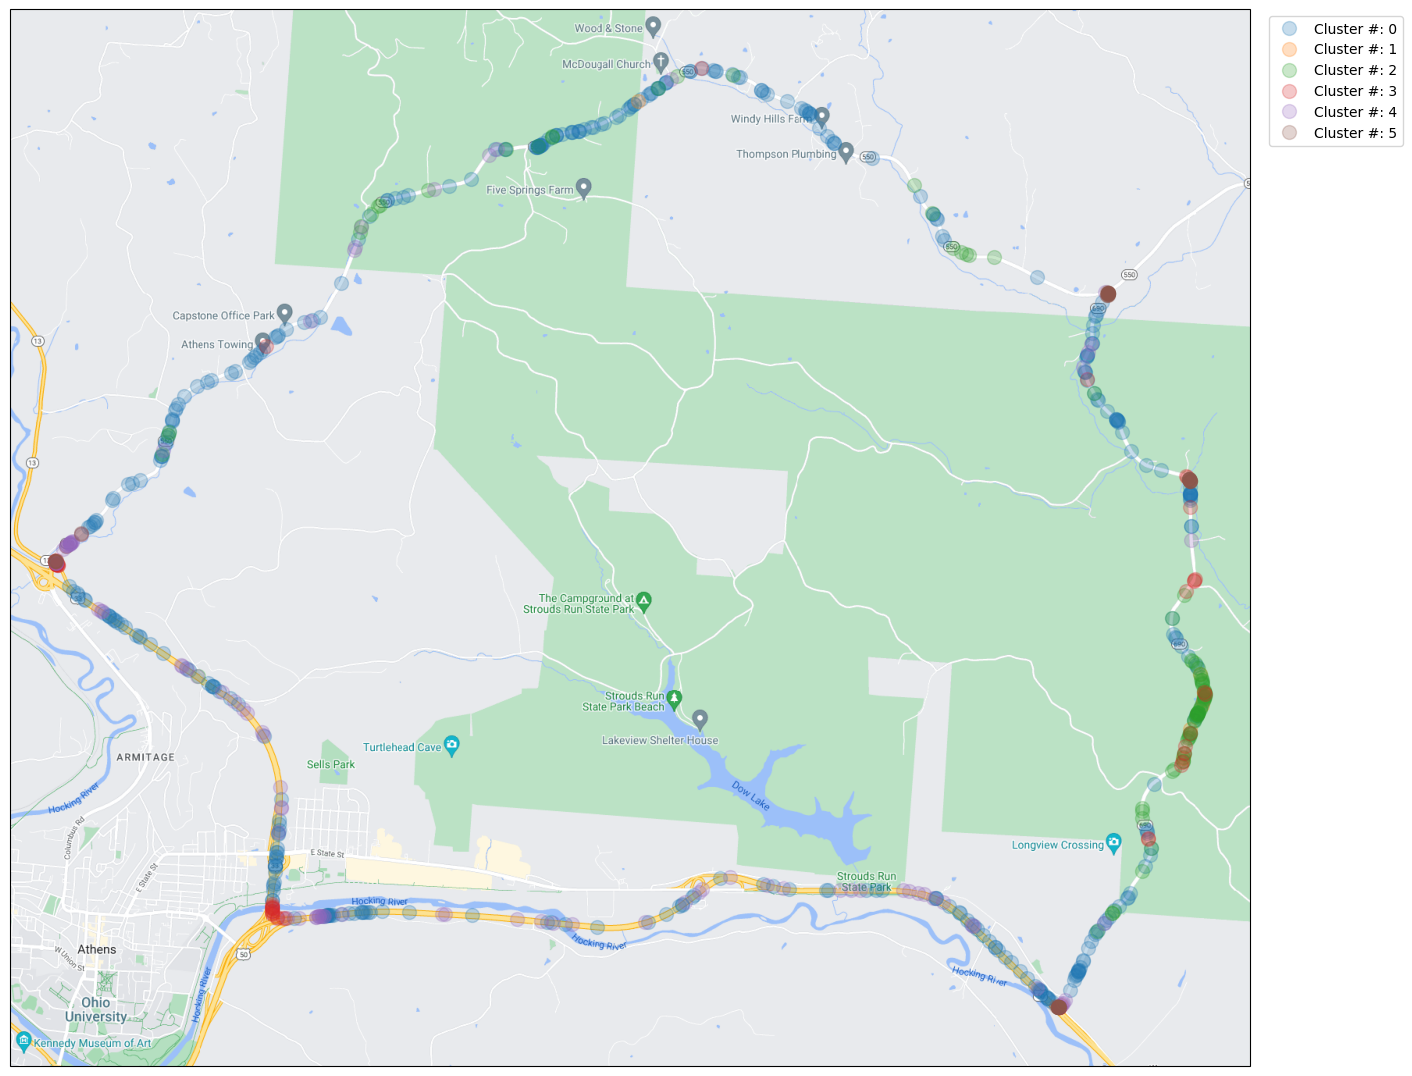

In [122]:
minLat = np.min( np.array( red_disengagement_df[ 'latitude' ] ) )

maxLat = np.max( np.array( red_disengagement_df[ 'latitude' ] ) )

minLon = np.min( np.array( red_disengagement_df[ 'longitude' ] ) )

maxLon = np.max( np.array( red_disengagement_df[ 'longitude' ] ) )

#

street_map = GoogleTiles( style = 'street' )

plt.figure( figsize = ( 16, 16 ) )

ax = plt.axes( projection = street_map.crs )

expansion_coeff = 0.005

ax.set_extent( [ minLon - expansion_coeff , maxLon + expansion_coeff, minLat - expansion_coeff, maxLat + expansion_coeff ], ccrs.PlateCarree() )

ax.add_image(street_map, 14)

for cluster_num in range( num_of_clusters ):

    latitude_list = red_disengagement_df[ red_disengagement_df[ 'cluster_num' ] == cluster_num ][ 'latitude' ]

    longitude_list = red_disengagement_df[ red_disengagement_df[ 'cluster_num' ] == cluster_num ][ 'longitude' ]

    plt.plot( longitude_list, latitude_list, transform = ccrs.PlateCarree(), marker = 'o', ls = '', ms = 10, label = f'Cluster #: { cluster_num }', alpha = 1 / 4 )

plt.legend( bbox_to_anchor = ( 1.01, 1.0 ), loc = 'upper left'  )

plt.show()

In [123]:
green_disengagement_df = pd.merge( green_combined_df_all, disengagement_df_mean, on = 'NearestDisengagementID', how = 'inner' )

green_disengagement_df = green_disengagement_df[ green_disengagement_df[ 'TernaryDrivingModeTransition' ] == -1 ]

green_disengagement_df = green_disengagement_df[ [ 'longitude', 'latitude', 'cluster_num' ] ]

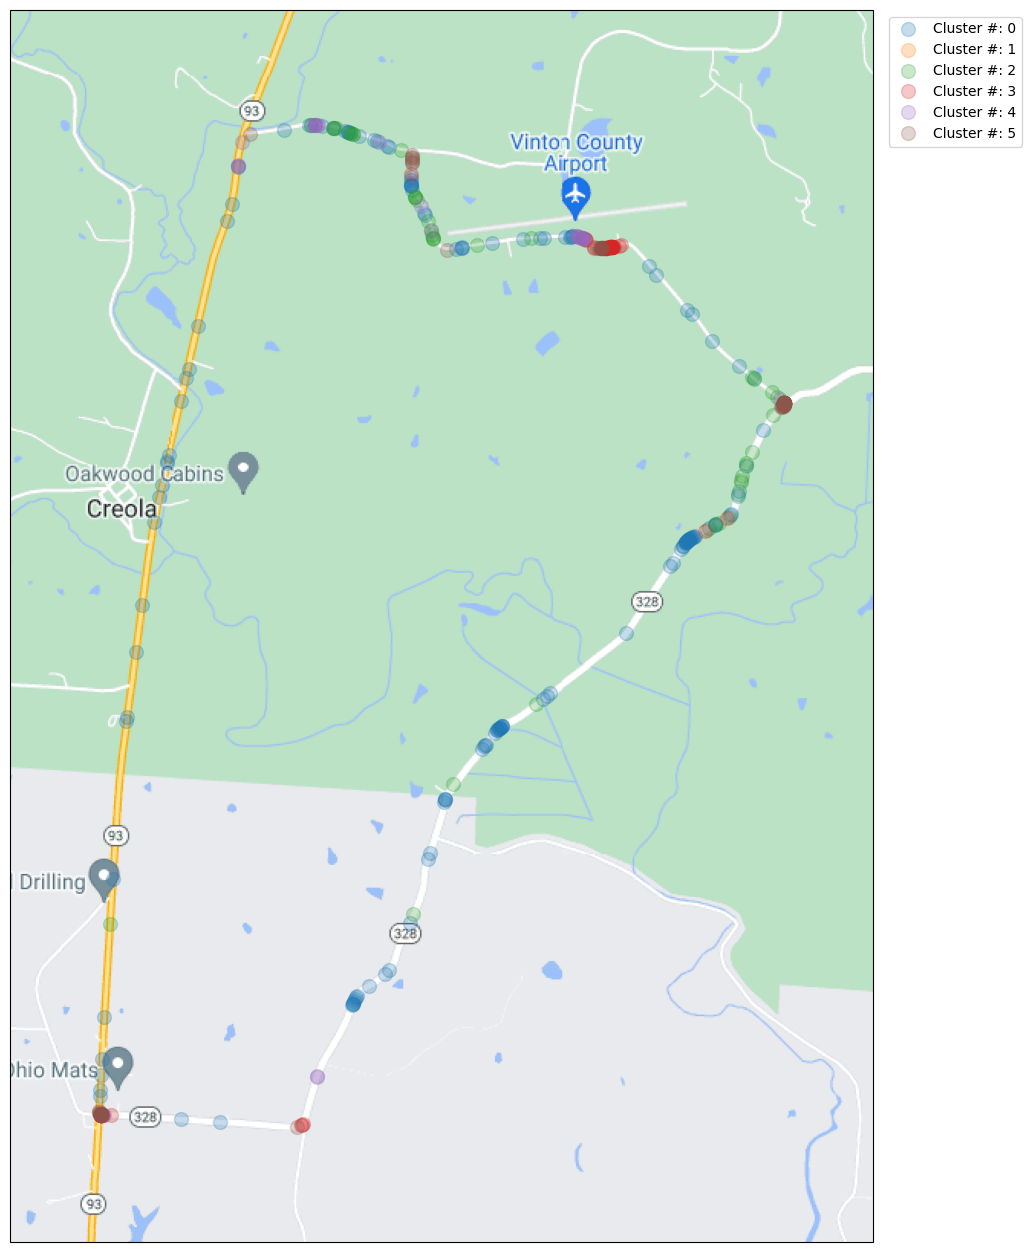

In [124]:
minLat = np.min( np.array( green_disengagement_df[ 'latitude' ] ) )

maxLat = np.max( np.array( green_disengagement_df[ 'latitude' ] ) )

minLon = np.min( np.array( green_disengagement_df[ 'longitude' ] ) )

maxLon = np.max( np.array( green_disengagement_df[ 'longitude' ] ) )

#

street_map = GoogleTiles( style = 'street' )

plt.figure( figsize = ( 16, 16 ) )

ax = plt.axes( projection = street_map.crs )

expansion_coeff = 0.005

ax.set_extent( [ minLon - expansion_coeff , maxLon + expansion_coeff, minLat - expansion_coeff, maxLat + expansion_coeff ], ccrs.PlateCarree() )

ax.add_image(street_map, 14)

for cluster_num in range( num_of_clusters ):

    latitude_list = green_disengagement_df[ green_disengagement_df[ 'cluster_num' ] == cluster_num ][ 'latitude' ]

    longitude_list = green_disengagement_df[ green_disengagement_df[ 'cluster_num' ] == cluster_num ][ 'longitude' ]

    plt.plot( longitude_list, latitude_list, transform = ccrs.PlateCarree(), marker = 'o', ls = '', ms = 10, label = f'Cluster #: { cluster_num }', alpha = 1 / 4 )

plt.legend( bbox_to_anchor = ( 1.01, 1.0 ), loc = 'upper left'  )

plt.show()

In [125]:
blue_disengagement_df = pd.merge( blue_combined_df_all, disengagement_df_mean, on = 'NearestDisengagementID', how = 'inner' )

blue_disengagement_df = blue_disengagement_df[ blue_disengagement_df[ 'TernaryDrivingModeTransition' ] == -1 ]

blue_disengagement_df = blue_disengagement_df[ [ 'longitude', 'latitude', 'cluster_num' ] ]

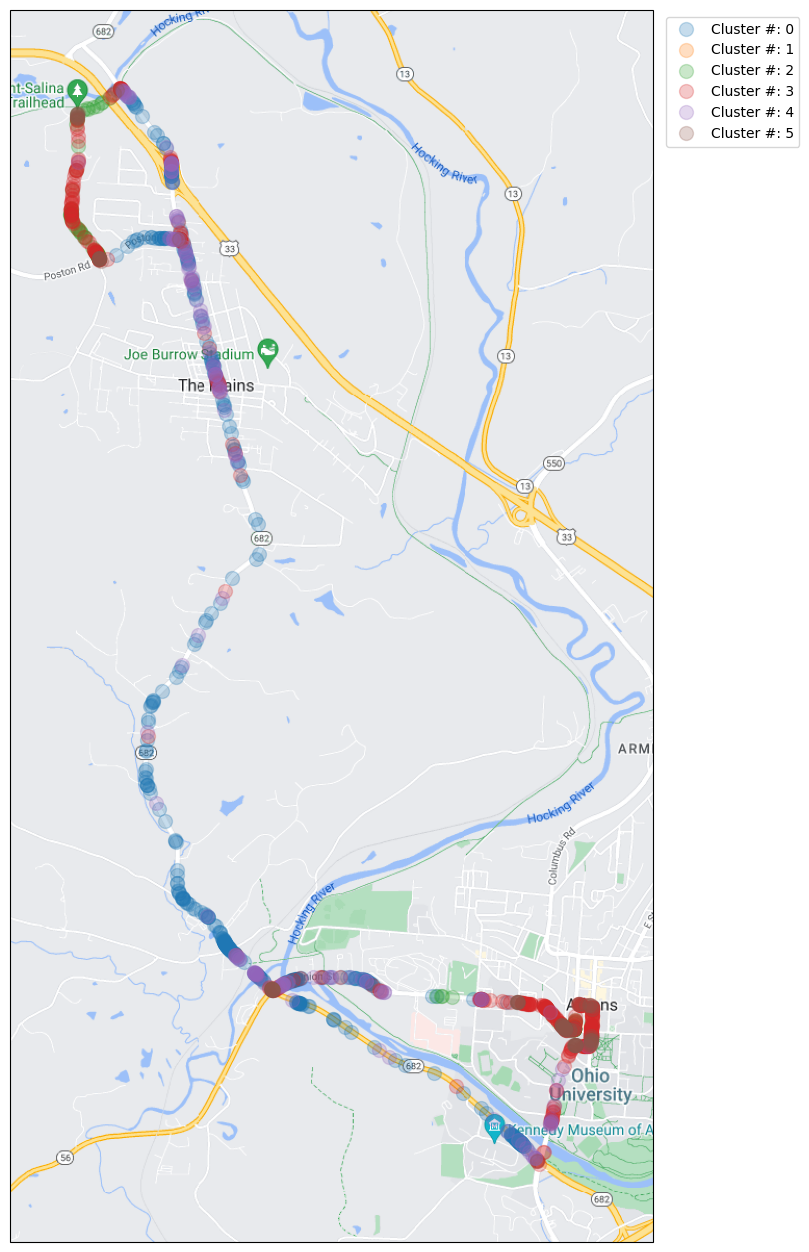

In [126]:
minLat = np.min( np.array( blue_disengagement_df[ 'latitude' ] ) )

maxLat = np.max( np.array( blue_disengagement_df[ 'latitude' ] ) )

minLon = np.min( np.array( blue_disengagement_df[ 'longitude' ] ) )

maxLon = np.max( np.array( blue_disengagement_df[ 'longitude' ] ) )

#

street_map = GoogleTiles( style = 'street' )

plt.figure( figsize = ( 16, 16 ) )

ax = plt.axes( projection = street_map.crs )

expansion_coeff = 0.005

ax.set_extent( [ minLon - expansion_coeff , maxLon + expansion_coeff, minLat - expansion_coeff, maxLat + expansion_coeff ], ccrs.PlateCarree() )

ax.add_image(street_map, 14)

for cluster_num in range( num_of_clusters ):

    latitude_list = blue_disengagement_df[ blue_disengagement_df[ 'cluster_num' ] == cluster_num ][ 'latitude' ]

    longitude_list = blue_disengagement_df[ blue_disengagement_df[ 'cluster_num' ] == cluster_num ][ 'longitude' ]

    plt.plot( longitude_list, latitude_list, transform = ccrs.PlateCarree(), marker = 'o', ls = '', ms = 10, label = f'Cluster #: { cluster_num }', alpha = 1 / 4 )

plt.legend( bbox_to_anchor = ( 1.01, 1.0 ), loc = 'upper left'  )

plt.show()